In [1]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import sympy
from operator import itemgetter
from sympy.physics.quantum.cg import CG

In [2]:
%run Q_and_M_database.ipynb

Number of misbehaved entries:  1
Total number of entries analyzed:  1208
Total number of entries uncleaned:  1208
Total number of entries inserted:  1175
Long lived magnetic dipole moments loaded as M_LL
Extract data with the function extract_mu(D_F), deliver the dataframe D_F as argument. The return is a list [Z, A, mu, un].
Number of misbehaved entries:  65
Total number of entries analyzed:  1356
Total number of entries uncleaned:  1356
Total number of entries inserted:  1164
Short lived magnetic dipole moments loaded as M_SL
Extract data with the function extract_mu(D_F), deliver the dataframe D_F as argument. The return is a list [Z, A, q, un, E, jp].
Magnetic dipole moments loaded as M
Extract data with the function extract_mu(D_F), deliver the dataframe D_F as argument. The return is a list [Z, A, mu, un].
Total number of entries uncleaned:  2564
Total number of entries inserted:  2339
Number of misbehaved entries:  164
Total number of entries analyzed:  1468
Total number of entr

## Harmonic oscillator radial wavefunctions

In [3]:
# Constants

hbar = 6.582119569*10**(-22)           # MeV*s
c = 2.99792458*10**(8)*10**(15)        # fm/s
m_p = 938.27/c**2                      # MeV*s²/fm²
m_n = 939.57/c**2                      # MeV*s²/fm²

def hbaromega(A):                          # Parameters: A mass number of nucleus
    return 45*A**(-1/3) - 25*A**(-2/3) 

def b(m,A):                                # Parameters: m mass of nucleon, A mass number of nucleus
    return hbar/np.sqrt(m*hbaromega(A))

In [4]:
# Harmonic oscillator radial wavefunction

def psiHO(r, n, l, m, A):                 # Parameters: r coordinate, n radial quantum number
                                          #             l orbital angular momentum,
                                          #             m mass of nucleon, A mass number of nucleus
    bv = b(m,A)
    norm = np.sqrt(2*scp.special.factorial(n)/(bv**3*scp.special.gamma(n+l+3/2)))
    return norm*(r/bv)**l*np.exp(-r**2/(2*bv**2))*scp.special.assoc_laguerre(r**2/bv**2, n, k = l+1/2)

In [5]:
# Harmonic oscillator total wavefunction

def PSI_HO(r, th, ph, n, l, j, proj, m, A):    # Parameters: r coordinate, n radial quantum number, th theta coordinate, ph azimutal coordinate
                                               #             l orbital angular momentum,
                                               #             j total angular momentum,
                                               #             proj is the projection of the total angular momentum
                                               #             m mass of nucleon, A mass number of nucleus
    bv = b(m,A)
    norm = np.sqrt(2*scp.special.factorial(n)/(bv**3*scp.special.gamma(n+l+3/2)))
    radial_wf = norm*(r/bv)**l*np.exp(-r**2/(2*bv**2))*scp.special.assoc_laguerre(r**2/bv**2, n, k = l+1/2)

    ang_spin_wf = np.array([0+0j,0+0j])
    for ml in range(-l,l+1):
        for ms in np.arange(-1/2,1/2+1,1):
            
            if ms == 1/2:
                ang_spin_wf += float(CG(l, ml, 1/2, ms, j, proj).doit())*scp.special.sph_harm(ml, l, th, ph)*np.array([1+0j, 0+0j])
            
            if ms == -1/2:
                ang_spin_wf += float(CG(l, ml, 1/2, ms, j, proj).doit())*scp.special.sph_harm(ml, l, th, ph)*np.array([0+0j, 1+0j])

    return radial_wf*ang_spin_wf

In [6]:
def wavefunction_evaluator(n, l, j, proj, m, A, x_interval, y_interval, z_interval, density):
    
       # Parameters:  n radial quantum number                       
       #             l orbital angular momentum,
       #             j total angular momentum,
       #             proj is the projection of the total angular momentum
       #             m mass of nucleon, A mass number of nucleus
       #             x_interval, y_interval and z_interval are the spatial intervals for the calculation of the w.f. They must be lists

    wf = []
    
    X = np.linspace(x_interval[0], x_interval[1], density)
    Y = np.linspace(y_interval[0], y_interval[1], density)
    Z = np.linspace(z_interval[0], z_interval[1], density)
    
    #probsum = 0
    
    for x in X:
        for y in Y:
            for z in Z:
                    
                r  = np.sqrt(x**2 + y**2 + z**2)
                th = np.arccos(z/r)
                ph = np.arctan(y/x) 
                
                ampl = PSI_HO(r, th, ph, n, l, j, proj, m, A)
                prob = abs(np.dot(ampl, np.conjugate(ampl)))
                
                wf.append([x,y,z,prob])
                
                #probsum += prob                
    return wf

In [7]:
# Function to compute <r^2>

def Integrand(r,n,l,m,N,Z,part):          # Parameters: r coordinate, n1, n2 radial quantum numbers, 
                                          #             l orbital angular momentum, N number of neutrons,
                                          #             Z number of protons, part = 0 for proton and 
                                          #             1 for neutron
    f1 = psiHO(r, n, l, m, Z+N)
    
    return r**4*f1*f1

def MSR(n,l,m,N,Z,part):
    
    return scp.integrate.quad(Integrand, 0, 200, args=(n,l,m,N,Z,part))[0]   # Integral up to 200fm

In [8]:
def Q_sp(n, l, m, N, Z, part):
    
    j1 = l+1/2
    j2 = l-1/2
    msr = MSR(n,l,m,N,Z,part)
    
    if l == 0:
        return [[2*j1, -1*part*(2*j1-1)/(2*j1+2)*msr]]
    else:
        return [[2*j1, -1*(1-part)*(2*j1-1)/(2*j1+2)*msr], [2*j2, -1*(1-part)*(2*j2-1)/(2*j2+2)*msr]]

In [9]:
def M_sp(j_max):
    
    gl_n = 0
    gl_p = 1
    gs_n = -3.826 
    gs_p = 5.586
    
    mump = []
    mupp = []
    mumn = []
    mupn = []
    
    jj = []
    
    for j in np.arange(0.5, j_max+1, 1):
        
        jj.append(j)
        mump.append(gl_p*j-(gs_p-gl_p)*(j)/(2*j+2))
        mupp.append(gl_p*j + (gs_p-gl_p)/2)
        
        mumn.append(gl_n*j-(gs_n-gl_n)*(j)/(2*j+2))
        mupn.append(gl_n*j + (gs_n-gl_n)/2)
        
    return jj, mump, mupp, mumn, mupn

# Quadrupole moments

### All this is odd-mass since we want to see the s.p. influence. Dominance of the <r²> term and its approxiamtion as $\frac{3}{5}r_0^2A^{2/3}$

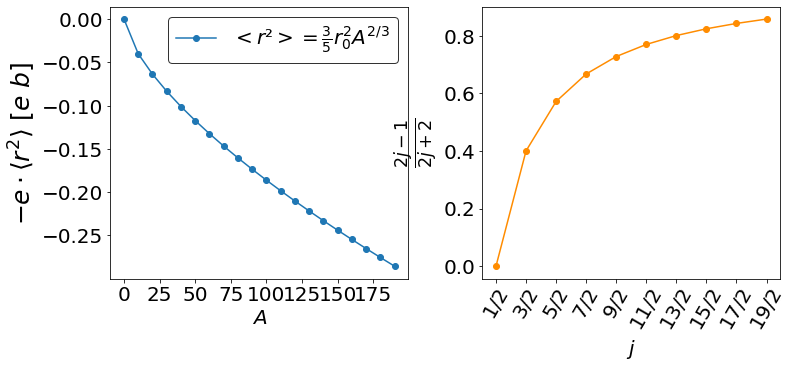

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Crear dos subgráficos en una fila

x1 = np.arange(0, 200, 10)
y1 = -1 * 3/5 * 1.2**2 * x1**(2/3)/100
axes[0].plot(x1, y1, "o-", label=r"$<r²>=\frac{3}{5}r_0^2A^{2/3}$")
axes[0].set_xlabel("$A$", fontsize=20)
axes[0].set_ylabel(r"$-e\cdot\langle r^2 \rangle$ [$e$ $b$]", fontsize=25)
axes[0].legend(fontsize=20, edgecolor="black", markerscale=1)

x2 = np.arange(0.5, 10.5, 1)
y2 = (2 * x2 - 1) / (2 * x2 + 2)
axes[1].plot(x2, y2, "o-", color="darkorange")
axes[1].set_xlabel("$j$", fontsize=20)
axes[1].set_ylabel(r"$\frac{2j-1}{2j+2}$", fontsize=25)
axes[1].set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5],["$1/2$","$3/2$","$5/2$","$7/2$","$9/2$","$11/2$","$13/2$","$15/2$","$17/2$","$19/2$"], fontsize=15, rotation=60)

for ax in axes:
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(20)

plt.subplots_adjust(wspace=0.25)
plt.savefig("RvsJsp.pdf", facecolor='white', bbox_inches='tight')
plt.show()


In [11]:
Q_odd_A = Q.copy()
Q_odd_A["A"] = pd.to_numeric(Q_odd_A["A"], downcast='integer', errors='coerce')
Q_odd_A = Q_odd_A[Q_odd_A["A"]%2==1]
dataq = extract_q(Q_odd_A, remove_unassigned="yes") # ONLY MEASUREMENTS WITH SIGN ARE USED

None of the available formats:


Z                                               48
Sym                                             Cd
A                                              109
E(level)                                       463
T_1/2                                       10.9µs
I                                            11/2-
Q(b)                                    [-0.92(9)]
Ref._Std.                                         
Method                                  systematic
NSR_Keynumber                                  not
Journal_reference    measured1978Sp09HFI4229(1978)
Name: 387, dtype: object

None of the available formats:


Z                                                    85
Sym                                                  At
A                                                   211
E(level)                                           1417
T_1/2                                            35.1ns
I                                                 21/2-
Q(b)                                     [(-)0.524(10)]
Ref._Std.                                              
Method                                             from
NSR_Keynumber                                     B(E2)
Journal_reference    notmeasured1995Ba66NPA591104(1996)
Name: 1073, dtype: object

None of the available formats:


Z                                                 87
Sym                                               Fr
A                                                213
E(level)                                        2538
T_1/2                                          238ns
I                                              29/2+
Q(b)                                      [-0.70(7)]
Ref._Std.                                           
Method                                    calculated
NSR_Keynumber                                    not
Journal_reference    measured1990By03NPA516145(1990)
Name: 1112, dtype: object

None of the available formats:


Z                                                   91
Sym                                                 Pa
A                                                  231
E(level)                                             0
T_1/2                                         3.3x104y
I                                                 3/2-
Q(b)                                        [-1.72(5)]
Ref._Std.                                             
Method                                            from
NSR_Keynumber                                    B(E2)
Journal_reference    notmeasured1978Fr28PLA69225(1975)
Name: 1135, dtype: object

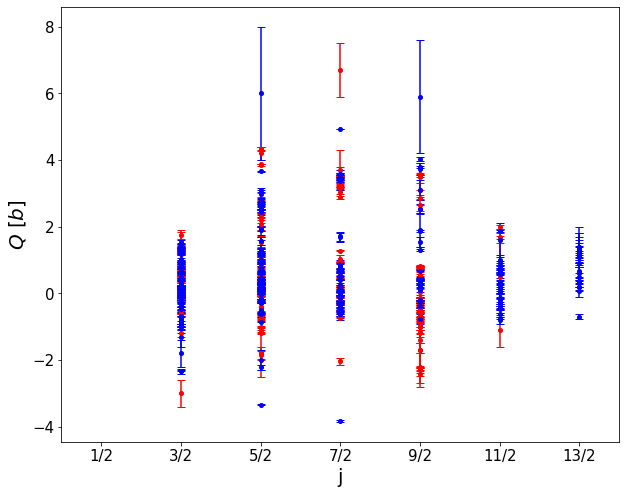

In [12]:
plt.figure(figsize=((10,8)))

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_mu_Z = [] 
dataq_lower_Z = [] 
dataq_upper_Z = [] 
#dataq_E_Z = [] 
dataq_jp_Z = []

# Odd N
#dataq_Z_N = [] 
#dataq_A_N = [] 
dataq_mu_N = [] 
dataq_lower_N = [] 
dataq_upper_N = [] 
#dataq_E_N = [] 
dataq_jp_N = []

for i in range(len(dataq[0])):
    
    if (dataq[0][i]%2==1):
        # Append in the odd Z array
        if "(" in dataq[5][i]:
            jjpp = dataq[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            
            if "/" not in dataq[5][i]:
                continue
            jjpp = float(dataq[5][i].split("/")[0])/2
            
        dataq_mu_Z.append(dataq[2][i])
        dataq_lower_Z.append(lower_error[i])
        dataq_upper_Z.append(upper_error[i])
        dataq_jp_Z.append(jjpp)
    
    if (dataq[0][i]%2==0):
        # Append in the odd N array
        if "(" in dataq[5][i]:
            jjpp = dataq[5][i].replace("(","")
            jjpp = jjpp.replace(")","")
            
            if "/" not in jjpp:
                continue
                
            jjpp = float(jjpp.split("/")[0])/2
        else:
            if "/" not in dataq[5][i]:
                continue
            jjpp = float(dataq[5][i].split("/")[0])/2
            
        dataq_mu_N.append(dataq[2][i])
        dataq_lower_N.append(lower_error[i])
        dataq_upper_N.append(upper_error[i])
        dataq_jp_N.append(jjpp)
    
asymmetric_error_Z = np.array(list(zip(dataq_lower_Z, dataq_upper_Z))).T
plt.errorbar(dataq_jp_Z, dataq_mu_Z, yerr=asymmetric_error_Z, fmt='o', color = "red" ,markersize=4, capsize=4) 
asymmetric_error_N = np.array(list(zip(dataq_lower_N, dataq_upper_N))).T
plt.errorbar(dataq_jp_N, dataq_mu_N, yerr=asymmetric_error_N, fmt='o', color = "blue", markersize=4, capsize=4) 


#plt.yticks(np.arange(int(min(dataq[2]))-1, int(max(dataq[2]))+2, 1), size=20)
plt.xlim(0,7)
#plt.ylim(-2.5,10.5)

plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],["1/2","3/2","5/2","7/2","9/2","11/2","13/2"], fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel("j", size=20)
plt.ylabel(r"$Q$ [$b$]", size=20)
plt.show()

### Long lived ones only

# Quadrupole moments

In [13]:
Q_ = Q.copy()
Q_["A"] = pd.to_numeric(Q_["A"], downcast='integer', errors='coerce')
dataq = extract_q(Q_, remove_unassigned="yes") # ONLY MEASUREMENTS WITH SIGN ARE USED

None of the available formats:


Z                                               48
Sym                                             Cd
A                                              109
E(level)                                       463
T_1/2                                       10.9µs
I                                            11/2-
Q(b)                                    [-0.92(9)]
Ref._Std.                                         
Method                                  systematic
NSR_Keynumber                                  not
Journal_reference    measured1978Sp09HFI4229(1978)
Name: 387, dtype: object

None of the available formats:


Z                                            50
Sym                                          Sn
A                                           116
E(level)                                   3547
T_1/2                                     833ns
I                                           10+
Q(b)                               [(-)0.41(4)]
Ref._Std.                                     B
Method                                      not
NSR_Keynumber                          measured
Journal_reference    1975Di02 PL B55 293 (1975)
Name: 457, dtype: object

None of the available formats:


Z                                                    84
Sym                                                  Po
A                                                   210
E(level)                                           1557
T_1/2                                              99ns
I                                                    8+
Q(b)                                         [-0.55(2)]
Ref._Std.                                              
Method                                             from
NSR_Keynumber                                     B(E2)
Journal_reference    notmeasured1991Be03NPA522483(1991)
Name: 1041, dtype: object

None of the available formats:


Z                                                    85
Sym                                                  At
A                                                   211
E(level)                                           1417
T_1/2                                            35.1ns
I                                                 21/2-
Q(b)                                     [(-)0.524(10)]
Ref._Std.                                              
Method                                             from
NSR_Keynumber                                     B(E2)
Journal_reference    notmeasured1995Ba66NPA591104(1996)
Name: 1073, dtype: object

None of the available formats:


Z                                                    86
Sym                                                  Rn
A                                                   212
E(level)                                           1694
T_1/2                                            0.91ms
I                                                    8+
Q(b)                                         [-0.18(2)]
Ref._Std.                                              
Method                                             from
NSR_Keynumber                                     B(E2)
Journal_reference    notmeasured1985Da13NPA441501(1985)
Name: 1088, dtype: object

None of the available formats:


Z                                                 87
Sym                                               Fr
A                                                213
E(level)                                        2538
T_1/2                                          238ns
I                                              29/2+
Q(b)                                      [-0.70(7)]
Ref._Std.                                           
Method                                    calculated
NSR_Keynumber                                    not
Journal_reference    measured1990By03NPA516145(1990)
Name: 1112, dtype: object

None of the available formats:


Z                                                   91
Sym                                                 Pa
A                                                  231
E(level)                                             0
T_1/2                                         3.3x104y
I                                                 3/2-
Q(b)                                        [-1.72(5)]
Ref._Std.                                             
Method                                            from
NSR_Keynumber                                    B(E2)
Journal_reference    notmeasured1978Fr28PLA69225(1975)
Name: 1135, dtype: object

In [89]:
Q

,Z,Sym,A,E(level),T_1/2,I,Q(b),Ref._Std.,Method,NSR_Keynumber,Journal_reference
0,1,H,2,0,stable,1+,+0.0028578(3),,"MB,R",1958Qu02,PR1121929(19)
1,3,Li,6,0,stable,1+,-0.000806(6),[Li7],MB,2005Bo45,PR C72 044309 (2005)
2,3,Li,7,0,stable,3/2-,-0.0400(3),,MB,2008Py02,MolPhys1061965(2008)
3,3,Li,8,0,840ms,2+,+0.0314(2),[Li7],β-NMR,2005Bo45,PR C72 044309 (2005)
4,3,Li,9,0,178ms,3/2-,-0.0304(2),[Li7],β-NMR,2011Av08,J Phys G 38 075102 (2011)
5,3,Li,11,0,8.75ms,3/2-,(-)0.0333(5),[Li7],β-NMR,2008Ne11,PRL 101 132502 (2008)
6,4,Be,9,0,stable,3/2-,+0.0529(4),,AB,1991Su05,CPL17791(1991)
7,4,Be,10,3368,0.125ps,2+,-0.08(7),,CER,2012Or05,PRC86041303(2012)
8,5,B,8,0,0.77s,2+,+0.0643(14),[11B],β-NQR,2006Su13,PR C74 024327 (2006)
9,5,B,10,0,stable,3+,+0.0846(2),[11B],AB,2008Py02/1970Ne21,Mol Phys 106 1965 (2008)/PR A2 1208 (1970)


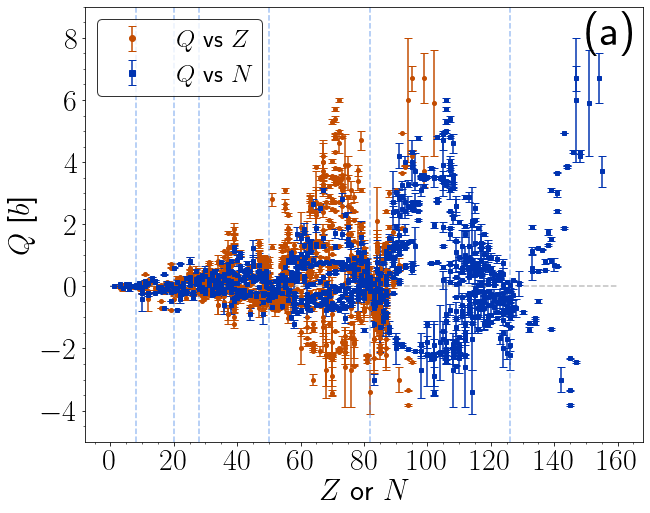

In [90]:
plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataq[0])):

    dataqq.append(dataq[2][i])
    dataq_A.append(dataq[1][i])
    dataq_Z.append(dataq[0][i])
    dataq_N.append(dataq[1][i] - dataq[0][i])

    dataq_lower.append(lower_error[i])
    dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "#c34c00" ,markersize=4, capsize=4, label="$Q$ vs $Z$") 
plt.errorbar(dataq_N, dataqq, yerr=asymmetric_error, fmt='s', color = "#0033b0" ,markersize=4, capsize=4, label="$Q$ vs $N$") 
plt.vlines(8, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(20, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(28, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(50, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(82, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(126, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)

plt.ylim(-5, 9)

plt.xticks(np.arange(0,170,20), fontsize=30)
plt.yticks(fontsize=30)

plt.xlabel("$Z$ or $N$", fontsize=30)
plt.ylabel(r"$Q$ [$b$]", size=30)
plt.text(150, 7.8, "(a)", fontsize=45, weight='bold' )
plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)

plt.legend(fontsize=25, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp1_cb.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb.pdf", facecolor='white', bbox_inches='tight')

plt.show()

# Ground states intrinsic quadrupole deformation

In [91]:
# Eq. 5.45 Takigawa. 5.10 Krane
def r2(A):
    return 3/5*1.2**2*A**(2/3)/100   # barns 

    
def Q_sp(j,A):
    return -(2*j-1)/(2*(j+1))*r2(A)

def Q_0_sp(j,A):
    return -(2*j+3)/(2*j)*r2(A)/100

def N(Z):
    return 0.910771*Z + 0.032701*(Z**(5/3))

In [92]:
Q_dep = Q.copy()
Q_dep["A"] = pd.to_numeric(Q_dep["A"], downcast='integer', errors='coerce')
Q_dep= Q_dep[Q_dep["E(level)"]=="0"]
Q_dep = Q_dep[~Q_dep["I"].str.contains("or")]
Q_dep = Q_dep[~Q_dep["I"].str.contains(",")]
Q_dep=Q_dep.reset_index()#.drop("index", axis="column")

dataqdep = extract_q(Q_dep, remove_unassigned="yes") # ONLY MEASUREMENTS WITH SIGN ARE USED

None of the available formats:


index                                             1135
Z                                                   91
Sym                                                 Pa
A                                                  231
E(level)                                             0
T_1/2                                         3.3x104y
I                                                 3/2-
Q(b)                                        [-1.72(5)]
Ref._Std.                                             
Method                                            from
NSR_Keynumber                                    B(E2)
Journal_reference    notmeasured1978Fr28PLA69225(1975)
Name: 585, dtype: object

In [93]:
Q_dep

,index,Z,Sym,A,E(level),T_1/2,I,Q(b),Ref._Std.,Method,NSR_Keynumber,Journal_reference
0,0,1,H,2,0,stable,1+,+0.0028578(3),,"MB,R",1958Qu02,PR1121929(19)
1,1,3,Li,6,0,stable,1+,-0.000806(6),[Li7],MB,2005Bo45,PR C72 044309 (2005)
2,2,3,Li,7,0,stable,3/2-,-0.0400(3),,MB,2008Py02,MolPhys1061965(2008)
3,3,3,Li,8,0,840ms,2+,+0.0314(2),[Li7],β-NMR,2005Bo45,PR C72 044309 (2005)
4,4,3,Li,9,0,178ms,3/2-,-0.0304(2),[Li7],β-NMR,2011Av08,J Phys G 38 075102 (2011)
5,5,3,Li,11,0,8.75ms,3/2-,(-)0.0333(5),[Li7],β-NMR,2008Ne11,PRL 101 132502 (2008)
6,6,4,Be,9,0,stable,3/2-,+0.0529(4),,AB,1991Su05,CPL17791(1991)
7,8,5,B,8,0,0.77s,2+,+0.0643(14),[11B],β-NQR,2006Su13,PR C74 024327 (2006)
8,9,5,B,10,0,stable,3+,+0.0846(2),[11B],AB,2008Py02/1970Ne21,Mol Phys 106 1965 (2008)/PR A2 1208 (1970)
9,10,5,B,11,0,stable,3/2-,+0.04059(10),,AB,2008Py02,MolPhys1061965(2008)


# Plot of <r²> phenomenological only

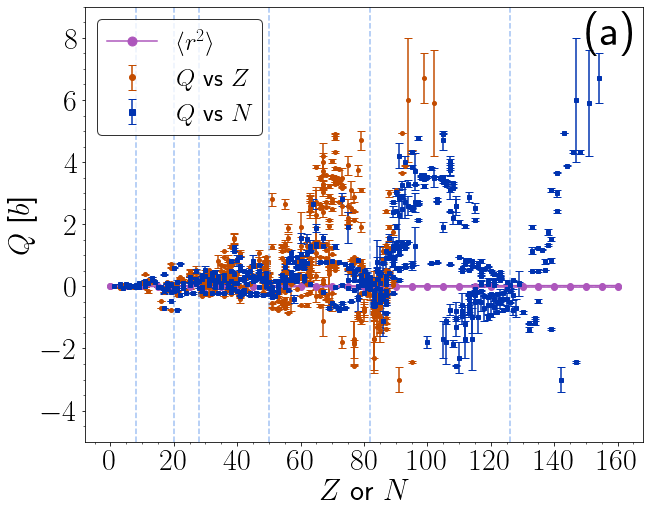

In [94]:
# s-p quadrupole

plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataqdep[3])):
    try: 
        if len(dataqdep[3][i]) == 2:
            lower_error.append(dataqdep[3][i][1])
            upper_error.append(dataqdep[3][i][0])
    except: 
        lower_error.append(dataqdep[3][i])
        upper_error.append(dataqdep[3][i])
# =================================================================================        

# Odd Z
#dataqdep_Z_Z = [] 
#dataqdep_A_Z = [] 
dataqdep_A = [] 
dataqdep_Z = [] 
dataqdep_N = [] 
dataqdepq = [] 
dataqdep_lower = [] 
dataqdep_upper = [] 
#dataqdep_E_Z = [] 
dataqdep_jp = []

for i in range(len(dataqdep[0])):

    dataqdepq.append(dataqdep[2][i])
    dataqdep_A.append(dataqdep[1][i])
    dataqdep_Z.append(dataqdep[0][i])
    dataqdep_N.append(dataqdep[1][i] - dataqdep[0][i])

    dataqdep_lower.append(lower_error[i])
    dataqdep_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataqdep_lower, dataqdep_upper))).T
plt.errorbar(dataqdep_Z, dataqdepq, yerr=asymmetric_error, fmt='o', color = "#c34c00" ,markersize=4, capsize=4, label="$Q$ vs $Z$") 
plt.errorbar(dataqdep_N, dataqdepq, yerr=asymmetric_error, fmt='s', color = "#0033b0" ,markersize=4, capsize=4, label="$Q$ vs $N$") 
plt.vlines(8, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(20, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(28, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(50, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(82, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(126, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)

plt.ylim(-5, 9)

plt.xticks(np.arange(0,170,20), fontsize=30)
plt.yticks(fontsize=30)

plt.xlabel("$Z$ or $N$", fontsize=30)
plt.ylabel(r"$Q$ [$b$]", size=30)
plt.text(150, 7.8, "(a)", fontsize=45, weight='bold' )
plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)



# # Adding sp-lines
# plt.plot(np.arange(0,165,5), Q_sp(1/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_sp(3/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_sp(5/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_sp(7/2,np.arange(0,165,5)), "o-")



# Adding sp-lines
plt.plot(np.arange(0,165,5), 3/5*0.1*1.2**2*np.arange(0,165,5)**(2/3)/100, "o-", c="#ad56bc")
plt.plot(np.arange(0,165,5), -3/5*0.1*1.2**2*np.arange(0,165,5)**(2/3)/100, "o-", c="#ad56bc",label=r"$\langle r^2\rangle$")


plt.legend(fontsize=25, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp1_cb-gs+r2.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-gs+r2.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-gs+r2.pdf", facecolor='white', bbox_inches='tight')

plt.show()

### Conversion of $Q$ to $Q_0$

In [95]:
# COnverting the spin values in floats
for j in range(len(dataqdep[5])):
    
    dataqdep[5][j]=dataqdep[5][j].replace(")","").replace("+","").replace("-","").replace("(","").replace("[","").replace("]","")
    
    if "/" in dataqdep[5][j]:
        num = int(dataqdep[5][j].split("/")[0])
        den = int(dataqdep[5][j].split("/")[1])
        dataqdep[5][j]=float(num/den)
        
    else:
        dataqdep[5][j] = int(dataqdep[5][j])  

In [96]:
# Converting Q into Q_o

for j in range(len(dataqdep[2])):

    dataqdep[2][j] = (dataqdep[5][j]+1)*(2*dataqdep[5][j]+3)/(dataqdep[5][j]*(2*dataqdep[5][j]-1))*dataqdep[2][j]

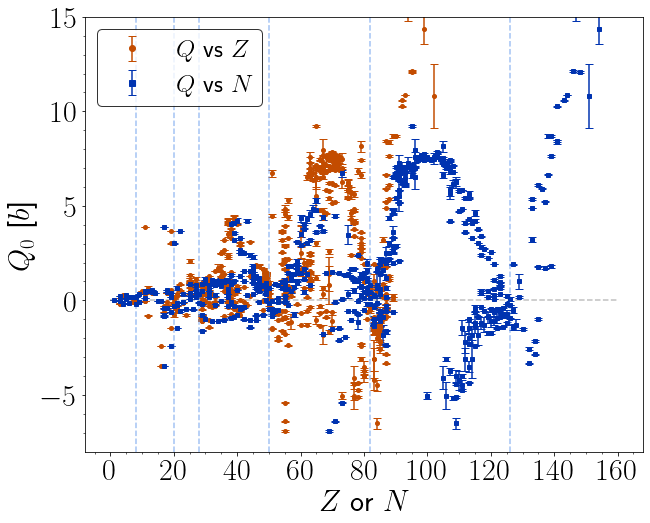

In [97]:
# s-p quadrupole

plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataqdep[3])):
    try: 
        if len(dataqdep[3][i]) == 2:
            lower_error.append(dataqdep[3][i][1])
            upper_error.append(dataqdep[3][i][0])
    except: 
        lower_error.append(dataqdep[3][i])
        upper_error.append(dataqdep[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataqdep[0])):

    dataqq.append(dataqdep[2][i])
    dataq_A.append(dataqdep[1][i])
    dataq_Z.append(dataqdep[0][i])
    dataq_N.append(dataqdep[1][i] - dataqdep[0][i])

    dataq_lower.append(lower_error[i])
    dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "#c34c00" ,markersize=4, capsize=4, label="$Q$ vs $Z$") 
plt.errorbar(dataq_N, dataqq, yerr=asymmetric_error, fmt='s', color = "#0033b0" ,markersize=4, capsize=4, label="$Q$ vs $N$") 
plt.vlines(8, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(20, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(28, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(50, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(82, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(126, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)

plt.ylim(-8, 15)

plt.xticks(np.arange(0,170,20), fontsize=30)
plt.yticks(fontsize=30)

plt.xlabel("$Z$ or $N$", fontsize=30)
plt.ylabel(r"$Q_0$ [$b$]", size=30)
#plt.text(150, 7.8, "(a)", fontsize=45, weight='bold' )
plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)



# # Adding sp-lines
# plt.plot(np.arange(0,165,5), Q_0_sp(1/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(3/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(5/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(7/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(9/2,np.arange(0,165,5)), "o-")

# plt.plot(np.arange(0,165,5), -1*Q_0_sp(1/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(3/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(5/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(7/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(9/2,np.arange(0,165,5)), "o-")

plt.legend(fontsize=25, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp1_cb-intr.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-intr.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-intr.pdf", facecolor='white', bbox_inches='tight')

plt.show()

In [98]:
dataq_df = pd.DataFrame(np.array(dataq).T, columns=["Z", "A", "q", "un", "E", "jp"])
dataq_df

,Z,A,q,un,E,jp
0,1,2,0.0028578,3e-07,0.0,1+
1,3,6,-0.000806,6e-06,0.0,1+
2,3,7,-0.04,0.0003,0.0,3/2-
3,3,8,0.0314,0.0002,0.0,2+
4,3,9,-0.0304,0.0002,0.0,3/2-
5,3,11,-0.0333,0.0005,0.0,3/2-
6,4,9,0.0529,0.0004,0.0,3/2-
7,4,10,-0.08,0.07,3368.0,2+
8,5,8,0.0643,0.0014,0.0,2+
9,5,10,0.0846,0.0002,0.0,3+


In [99]:
# Libraries

import numpy as np
import matplotlib.pyplot as plt
import scipy as scp
import sympy
from operator import itemgetter

# Constants
hbar = 6.582119569*10**(-22)           # MeV*s
c = 2.99792458*10**(8)*10**(15)        # fm/s
m_p = 938.27/c**2                      # MeV*s²/fm²
m_n = 939.57/c**2                      # MeV*s²/fm²

def hbaromega(A):                          # Parameters: A mass number of nucleus
    return 45*A**(-1/3) - 25*A**(-2/3) 

def b(m,A):                                # Parameters: m mass of nucleon, A mass number of nucleus
    return hbar/np.sqrt(m*hbaromega(A))


# Harmonic oscillator radial wavefunction
def psiHO(r, n, l, m, A):                 # Parameters: r coordinate, n radial quantum number
                                          #             l orbital angular momentum,
                                          #             m mass of nucleon, A mass number of nucleus
    bv = b(m,A)
    norm = np.sqrt(2*scp.special.factorial(n)/(bv**3*scp.special.gamma(n+l+3/2)))
    return norm*(r/bv)**l*np.exp(-r**2/(2*bv**2))*scp.special.assoc_laguerre(r**2/bv**2, n, k = l+1/2)

# Function to compute matrix elements <r^2>
def Integrand(r,n1,n2,l,j,m,A,part):           # Parameters: r coordinate, n1, n2 radial quantum numbers, 
                                                 #             l orbital angular momentum, N number of neutrons,
                                                 #             Z number of protons, part = 0 for proton and 
                                                 #             1 for neutron, j total angular momentum
    f1 = psiHO(r, n1, l, m, A)
    
    return r**4*f1*f1

def MatrixElement(n1,n2,l,j,m,A,part):
    
    return scp.integrate.quad(Integrand, 0, 500, args=(n1,n2,l,j,m,A,part))[0]   # Integral up to 200fm

In [100]:
Shells = [[[0,0,1/2, 2],
[0,1,3/2, 6],       #Shell N=8
[0,1,1/2, 8]],
[[0,2,5/2, 14],
 [1,0,1/2, 16],
 [0,2,3/2, 20]],      #Shell N=20  
[[0,3,7/2, 28]],     #Shell N=28
[[1,1,3/2, 32], 
 [0,3,5/2, 38],      #Shell N=50  
 [1,1,1/2, 40],
 [0,4,9/2, 50]],
[[0,4,7/2, 58], 
 [1,2,5/2, 64],      #Shell N=82  
 [1,2,3/2, 68],
 [2,0,1/2, 70],
 [0,5,11/2,82]],
[[0,5,9/2, 92], 
 [1,3,7/2, 100]]]
                #,      #Shell N=126  
#  [1,3,5/2, 106],
#  [2,1,3/2, 110],
#  [2,1,1/2, 112],
#  [0,6,13/2, 126]],
# [[1,4,9/2, 136], 
#  [2,2,5/2, 142],      #Shell N=184  
#  [0,6,11/2, 154],
#  [1,4,7/2, 162],
#  [3,0,1/2, 164],
#  [1,2,3/2, 168],
#  [0,7,15/2, 184]]]

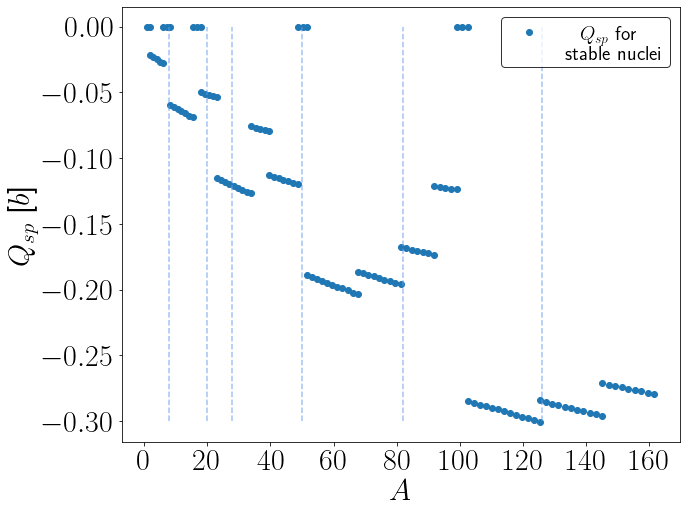

In [101]:
Q_values = []
Q0_values = []
N_values = []
N_carry = 1

plt.figure(figsize=((10,8)))


for shell in Shells:
    for orbit in shell:
        
        n = orbit[0]
        l = orbit[1]
        j = orbit[2]
        N_shell = orbit[3]  # Total accumulated particles
        
        for proton in range(N_carry, N_shell+1):
            
            A = int(proton + N(proton))
            Q_sp_ = -(2*j-1)/(2*(j+1))*MatrixElement(n,n,l,j,m_n,A,0)/100   #barns
            Q0_sp_ = -(2*j+3)/(2*(j))*MatrixElement(n,n,l,j,m_n,A,0)/100   #barns
            
            Q_values.append(Q_sp_)
            Q0_values.append(Q0_sp_)
            N_values.append(N(proton))
            
            N_carry = N_shell
            
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel("$A$", fontsize=30)
plt.ylabel("$Q_{sp}$ [$b$]", fontsize=30)
plt.plot(N_values, Q_values,"o",label=r"$Q_{sp}$ for \\ stable nuclei")

plt.vlines(8, -0.3, 0, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(20, -0.3, 0, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(28, -0.3, 0, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(50, -0.3, 0, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(82, -0.3, 0, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(126, -0.3, 0, colors='#659bec', linestyles='--', alpha=0.6)


plt.legend(fontsize=20, edgecolor="black", loc="upper right", markerscale=1)
plt.savefig("Qsp-shells.pdf", facecolor='white', bbox_inches='tight')

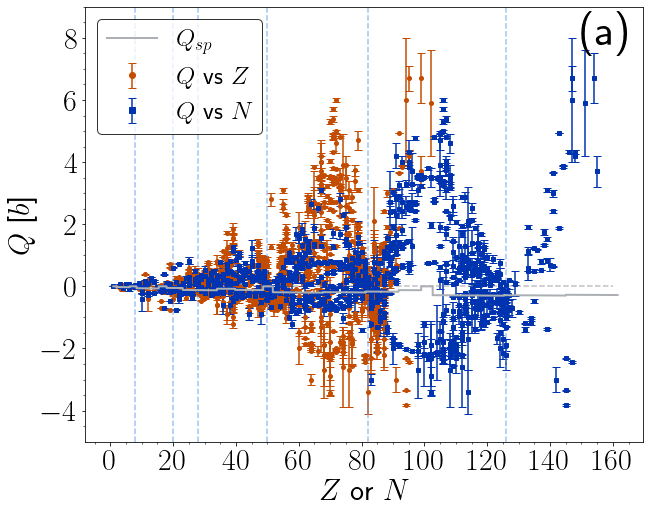

In [102]:
# s-p quadrupole

plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataq[3])):
    try: 
        if len(dataq[3][i]) == 2:
            lower_error.append(dataq[3][i][1])
            upper_error.append(dataq[3][i][0])
    except: 
        lower_error.append(dataq[3][i])
        upper_error.append(dataq[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataq[0])):

    dataqq.append(dataq[2][i])
    dataq_A.append(dataq[1][i])
    dataq_Z.append(dataq[0][i])
    dataq_N.append(dataq[1][i] - dataq[0][i])

    dataq_lower.append(lower_error[i])
    dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "#c34c00" ,markersize=4, capsize=4, label="$Q$ vs $Z$") 
plt.errorbar(dataq_N, dataqq, yerr=asymmetric_error, fmt='s', color = "#0033b0" ,markersize=4, capsize=4, label="$Q$ vs $N$") 
plt.vlines(8, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(20, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(28, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(50, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(82, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(126, -5, 9, colors='#659bec', linestyles='--', alpha=0.6)

plt.ylim(-5, 9)

plt.xticks(np.arange(0,170,20), fontsize=30)
plt.yticks(fontsize=30)

plt.xlabel("$Z$ or $N$", fontsize=30)
plt.ylabel(r"$Q$ [$b$]", size=30)
plt.text(150, 7.8, "(a)", fontsize=45, weight='bold' )
plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)

#plt.plot(N_values, -1*np.array(Q_values),"-",c="#acb0b4", zorder=30, markersize=40, linewidth=2)
plt.plot(N_values, Q_values,"-",c="#acb0b4", zorder=30, markersize=40, linewidth=2,label=r"$Q_{sp}$")


plt.legend(fontsize=25, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp1_cb-sp.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-sp.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-sp.pdf", facecolor='white', bbox_inches='tight')

plt.show()

/tmp/ipykernel_6951/1645849242.py:87: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecWolor" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("QExp1_cb-intr-sp.png", dpi=300, facecWolor='white', bbox_inches='tight')


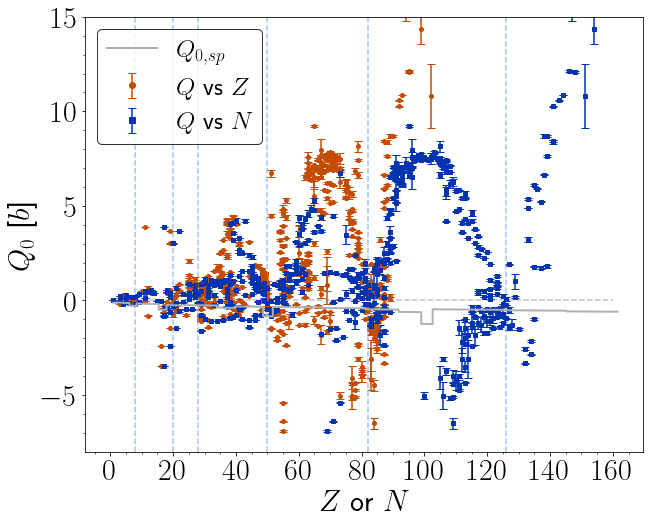

In [103]:
# s-p quadrupole

plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataqdep[3])):
    try: 
        if len(dataqdep[3][i]) == 2:
            lower_error.append(dataqdep[3][i][1])
            upper_error.append(dataqdep[3][i][0])
    except: 
        lower_error.append(dataqdep[3][i])
        upper_error.append(dataqdep[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataqdep[0])):

    dataqq.append(dataqdep[2][i])
    dataq_A.append(dataqdep[1][i])
    dataq_Z.append(dataqdep[0][i])
    dataq_N.append(dataqdep[1][i] - dataqdep[0][i])

    dataq_lower.append(lower_error[i])
    dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "#c34c00" ,markersize=4, capsize=4, label="$Q$ vs $Z$") 
plt.errorbar(dataq_N, dataqq, yerr=asymmetric_error, fmt='s', color = "#0033b0" ,markersize=4, capsize=4, label="$Q$ vs $N$") 
plt.vlines(8, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(20, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(28, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(50, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(82, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(126, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)

plt.ylim(-8, 15)

plt.xticks(np.arange(0,170,20), fontsize=30)
plt.yticks(fontsize=30)

plt.xlabel("$Z$ or $N$", fontsize=30)
plt.ylabel(r"$Q_0$ [$b$]", size=30)
#plt.text(150, 7.8, "(a)", fontsize=45, weight='bold' )
plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)



# # Adding sp-lines
# plt.plot(np.arange(0,165,5), Q_0_sp(1/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(3/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(5/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(7/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(9/2,np.arange(0,165,5)), "o-")

# plt.plot(np.arange(0,165,5), -1*Q_0_sp(1/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(3/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(5/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(7/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(9/2,np.arange(0,165,5)), "o-")

#plt.plot(N_values, -1*np.array(Q0_values),"-",c="#acb0b4", zorder=30, markersize=40, linewidth=2)
plt.plot(N_values, Q0_values,"-",c="#acb0b4", zorder=30, markersize=40, linewidth=2,label=r"$Q_{0,sp}$")



plt.legend(fontsize=25, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp1_cb-intr-sp.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-intr-sp.png", dpi=300, facecWolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-intr-sp.pdf", facecolor='white', bbox_inches='tight')

plt.show()

# Plot with respect to odd-Z or odd-N

In [137]:
Q_dep = Q.copy()
Q_dep["A"] = pd.to_numeric(Q_dep["A"], downcast='integer', errors='coerce')
Q_dep= Q_dep[Q_dep["E(level)"]=="0"]
Q_dep = Q_dep[~Q_dep["I"].str.contains("or")]
Q_dep = Q_dep[~Q_dep["I"].str.contains(",")]
Q_dep_odd_A = Q_dep[Q_dep["A"]%2==1]
Q_dep_odd_A=Q_dep_odd_A.reset_index()#.drop("index", axis="column")

dataqdep_odd = extract_q(Q_dep_odd_A, remove_unassigned="yes") # ONLY MEASUREMENTS WITH SIGN ARE USED

None of the available formats:


index                                             1135
Z                                                   91
Sym                                                 Pa
A                                                  231
E(level)                                             0
T_1/2                                         3.3x104y
I                                                 3/2-
Q(b)                                        [-1.72(5)]
Ref._Std.                                             
Method                                            from
NSR_Keynumber                                    B(E2)
Journal_reference    notmeasured1978Fr28PLA69225(1975)
Name: 401, dtype: object

In [138]:
Q_dep_odd_A

,index,Z,Sym,A,E(level),T_1/2,I,Q(b),Ref._Std.,Method,NSR_Keynumber,Journal_reference
0,2,3,Li,7,0,stable,3/2-,-0.0400(3),,MB,2008Py02,MolPhys1061965(2008)
1,4,3,Li,9,0,178ms,3/2-,-0.0304(2),[Li7],β-NMR,2011Av08,J Phys G 38 075102 (2011)
2,5,3,Li,11,0,8.75ms,3/2-,(-)0.0333(5),[Li7],β-NMR,2008Ne11,PRL 101 132502 (2008)
3,6,4,Be,9,0,stable,3/2-,+0.0529(4),,AB,1991Su05,CPL17791(1991)
4,10,5,B,11,0,stable,3/2-,+0.04059(10),,AB,2008Py02,MolPhys1061965(2008)
5,12,5,B,13,0,17.3ms,3/2-,(+)0.0365(8),[11B],β-NMR,2004Na38,NP A746 509c (2004)
6,14,5,B,15,0,9.9ms,3/2-,0.0379(11),[11B],β-NMR,1996Iz01,PL B366 51 (1996)
7,15,5,B,17,0,5.1ms,(3/2-),0.0385(15),[11B],β-NMR,2003Og03,PR C67 064308 (2003)
8,16,6,C,11,0,20.4m,3/2-,0.0333(2),,AB,2008Py02/1969Sc34,MolPhys1061965(2008)/PR181137(1969)
9,22,8,O,13,0,8..6ms,3/2-,0.0111(8),[17O],β-NQR,1999Ma46,PL B459 81 (1999)


In [139]:
Q_dep

,Z,Sym,A,E(level),T_1/2,I,Q(b),Ref._Std.,Method,NSR_Keynumber,Journal_reference
0,1,H,2,0,stable,1+,+0.0028578(3),,"MB,R",1958Qu02,PR1121929(19)
1,3,Li,6,0,stable,1+,-0.000806(6),[Li7],MB,2005Bo45,PR C72 044309 (2005)
2,3,Li,7,0,stable,3/2-,-0.0400(3),,MB,2008Py02,MolPhys1061965(2008)
3,3,Li,8,0,840ms,2+,+0.0314(2),[Li7],β-NMR,2005Bo45,PR C72 044309 (2005)
4,3,Li,9,0,178ms,3/2-,-0.0304(2),[Li7],β-NMR,2011Av08,J Phys G 38 075102 (2011)
5,3,Li,11,0,8.75ms,3/2-,(-)0.0333(5),[Li7],β-NMR,2008Ne11,PRL 101 132502 (2008)
6,4,Be,9,0,stable,3/2-,+0.0529(4),,AB,1991Su05,CPL17791(1991)
8,5,B,8,0,0.77s,2+,+0.0643(14),[11B],β-NQR,2006Su13,PR C74 024327 (2006)
9,5,B,10,0,stable,3+,+0.0846(2),[11B],AB,2008Py02/1970Ne21,Mol Phys 106 1965 (2008)/PR A2 1208 (1970)
10,5,B,11,0,stable,3/2-,+0.04059(10),,AB,2008Py02,MolPhys1061965(2008)


/tmp/ipykernel_6951/3268405194.py:83: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecWolor" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("QExp1_cb-intr-oddA.png", dpi=300, facecWolor='white', bbox_inches='tight')


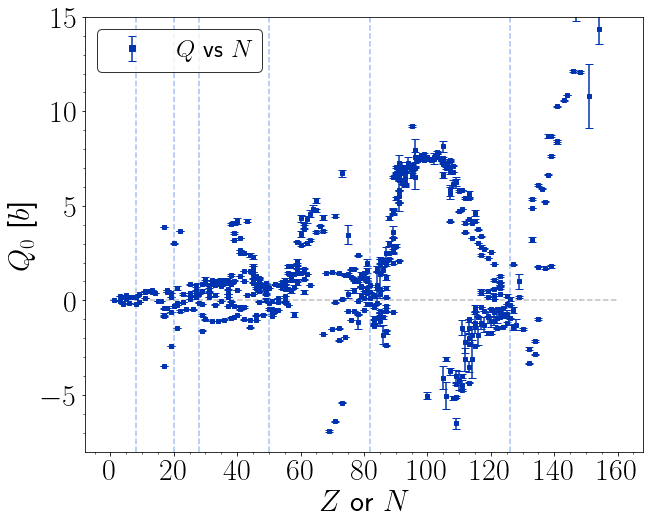

In [140]:
# s-p quadrupole

plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataqdep[3])):
    try: 
        if len(dataqdep[3][i]) == 2:
            lower_error.append(dataqdep[3][i][1])
            upper_error.append(dataqdep[3][i][0])
    except: 
        lower_error.append(dataqdep[3][i])
        upper_error.append(dataqdep[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 
dataq_Z = [] 
dataq_N = [] 
dataqq = [] 
dataq_lower = [] 
dataq_upper = [] 
#dataq_E_Z = [] 
dataq_jp = []

for i in range(len(dataqdep[0])):

    dataqq.append(dataqdep[2][i])
    dataq_A.append(dataqdep[1][i])
    dataq_Z.append(dataqdep[0][i])
    dataq_N.append(dataqdep[1][i] - dataqdep[0][i])

    dataq_lower.append(lower_error[i])
    dataq_upper.append(upper_error[i])
    
asymmetric_error = np.array(list(zip(dataq_lower, dataq_upper))).T
#plt.errorbar(dataq_Z, dataqq, yerr=asymmetric_error, fmt='o', color = "#c34c00" ,markersize=4, capsize=4, label="$Q$ vs $Z$") 
plt.errorbar(dataq_N, dataqq, yerr=asymmetric_error, fmt='s', color = "#0033b0" ,markersize=4, capsize=4, label="$Q$ vs $N$") 
plt.vlines(8, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(20, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(28, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(50, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(82, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(126, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)

plt.ylim(-8, 15)

plt.xticks(np.arange(0,170,20), fontsize=30)
plt.yticks(fontsize=30)

plt.xlabel("$Z$ or $N$", fontsize=30)
plt.ylabel(r"$Q_0$ [$b$]", size=30)
#plt.text(150, 7.8, "(a)", fontsize=45, weight='bold' )
plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)



# # Adding sp-lines
# plt.plot(np.arange(0,165,5), Q_0_sp(1/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(3/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(5/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(7/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(9/2,np.arange(0,165,5)), "o-")

# plt.plot(np.arange(0,165,5), -1*Q_0_sp(1/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(3/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(5/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(7/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(9/2,np.arange(0,165,5)), "o-")


plt.legend(fontsize=25, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp1_cb-intr-oddA.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-intr-oddA.png", dpi=300, facecWolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-intr-oddA.pdf", facecolor='white', bbox_inches='tight')

plt.show()

In [141]:
# COnverting the spin values in floats
for j in range(len(dataqdep_odd[5])):
    
    dataqdep_odd[5][j]=dataqdep_odd[5][j].replace(")","").replace("+","").replace("-","").replace("(","").replace("[","").replace("]","")
    
    if "/" in dataqdep_odd[5][j]:
        num = int(dataqdep_odd[5][j].split("/")[0])
        den = int(dataqdep_odd[5][j].split("/")[1])
        dataqdep_odd[5][j]=float(num/den)
        
    else:
        dataqdep_odd[5][j] = int(dataqdep_odd[5][j])  

In [142]:
# Converting Q into Q_o along with the errors

for j in range(len(dataqdep_odd[2])):

    dataqdep_odd[2][j] = (dataqdep_odd[5][j]+1)*(2*dataqdep_odd[5][j]+3)/(dataqdep_odd[5][j]*(2*dataqdep_odd[5][j]-1))*dataqdep_odd[2][j] 
    dataqdep_odd[3][j] = (dataqdep_odd[5][j]+1)*(2*dataqdep_odd[5][j]+3)/(dataqdep_odd[5][j]*(2*dataqdep_odd[5][j]-1))*dataqdep_odd[3][j]
    

In [143]:
Shells = [[[0,0,1/2, 2],
[0,1,3/2, 6],       #Shell N=8
[0,1,1/2, 8]],
[[0,2,5/2, 14],
 [1,0,1/2, 16],
 [0,2,3/2, 20]],      #Shell N=20  
[[0,3,7/2, 28]],     #Shell N=28
[[1,1,3/2, 32], 
 [0,3,5/2, 38],      #Shell N=50  
 [1,1,1/2, 40],
 [0,4,9/2, 50]],
[[0,4,7/2, 58], 
 [1,2,5/2, 64],      #Shell N=82  
 [1,2,3/2, 68],
 [2,0,1/2, 70],
 [0,5,11/2,82]],
[[0,5,9/2, 92], 
 [1,3,7/2, 100]]]
                #,      #Shell N=126  
#  [1,3,5/2, 106],
#  [2,1,3/2, 110],
#  [2,1,1/2, 112],
#  [0,6,13/2, 126]],
# [[1,4,9/2, 136], 
#  [2,2,5/2, 142],      #Shell N=184  
#  [0,6,11/2, 154],
#  [1,4,7/2, 162],
#  [3,0,1/2, 164],
#  [1,2,3/2, 168],
#  [0,7,15/2, 184]]]

In [144]:
Q_values = []
Q0_values = []
N_values = []
N_carry = 1


for shell in Shells:
    for orbit in shell:
        
        n = orbit[0]
        l = orbit[1]
        j = orbit[2]
        N_shell = orbit[3]  # Total accumulated particles
        
        for proton in range(N_carry, N_shell+1):
            
            A = int(proton + N(proton))
            Q_sp_ = -(2*j-1)/(2*(j+1))*MatrixElement(n,n,l,j,m_n,A,0)/100   #barns
            Q0_sp_ = -(2*j+3)/(2*(j))*MatrixElement(n,n,l,j,m_n,A,0)/100   #barns
            
            Q_values.append(Q_sp_)
            Q0_values.append(Q0_sp_)
            N_values.append(N(proton))
            
            N_carry = N_shell
            

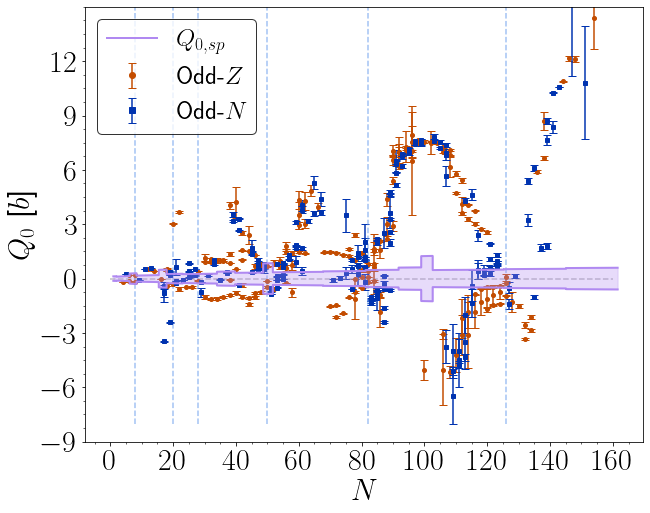

In [150]:
# s-p quadrupole

plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataqdep_odd[3])):
    try: 
        if len(dataqdep_odd[3][i]) == 2:
            lower_error.append(dataqdep_odd[3][i][1])
            upper_error.append(dataqdep_odd[3][i][0])
    except: 
        lower_error.append(dataqdep_odd[3][i])
        upper_error.append(dataqdep_odd[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 

dataq_A_oddZ = [] 
dataq_A_oddN = [] 

dataq_Z = [] 
dataq_N = [] 

dataqq_oddZ = [] 
dataq_lower_oddZ = [] 
dataq_upper_oddZ = [] 

dataqq_oddN = [] 
dataq_lower_oddN = [] 
dataq_upper_oddN = [] 

dataq_loweroddZ = [] 
dataq_upperoddZ = [] 

dataq_loweroddN = [] 
dataq_upperoddN = [] 

dataq_jp = []


for i in range(len(dataqdep_odd[0])):
    
    if dataqdep_odd[0][i]%2==1:
        dataq_Z.append(dataqdep_odd[1][i] - dataqdep_odd[0][i])
        dataq_A_oddZ.append(dataqdep_odd[1][i])
        dataqq_oddZ.append(dataqdep_odd[2][i])
        dataq_loweroddZ.append(lower_error[i])
        dataq_upperoddZ.append(upper_error[i])
        
    else:
        
        dataq_N.append(dataqdep_odd[1][i] - dataqdep_odd[0][i])
        dataq_A_oddN.append(dataqdep_odd[1][i])
        dataqq_oddN.append(dataqdep_odd[2][i])    
        dataq_loweroddN.append(lower_error[i])
        dataq_upperoddN.append(upper_error[i])   
        
    
asymmetric_erroroddZ = np.array(list(zip(dataq_loweroddZ, dataq_upperoddZ))).T
asymmetric_erroroddN = np.array(list(zip(dataq_loweroddN, dataq_upperoddN))).T

plt.errorbar(dataq_Z, dataqq_oddZ, yerr=asymmetric_erroroddZ, fmt='o', color = "#c34c00" ,markersize=4, capsize=4, label="Odd-$Z$") 
plt.errorbar(dataq_N, dataqq_oddN, yerr=asymmetric_erroroddN, fmt='s', color = "#0033b0" ,markersize=4, capsize=4, label="Odd-$N$") 
plt.vlines(8, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(20, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(28, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(50, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(82, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(126, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)

plt.ylim(-8, 15)

plt.xticks(np.arange(0,300,20), fontsize=30)
plt.yticks(np.arange(-9, 15,3), fontsize=30)

plt.xlabel("$N$", fontsize=30)
plt.ylabel(r"$Q_0$ [$b$]", size=30)
#plt.text(150, 7.8, "(a)", fontsize=45, weight='bold' )
plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)



# # Adding sp-lines
# plt.plot(np.arange(0,165,5), Q_0_sp(1/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(3/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(5/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(7/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(9/2,np.arange(0,165,5)), "o-")

# plt.plot(np.arange(0,165,5), -1*Q_0_sp(1/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(3/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(5/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(7/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(9/2,np.arange(0,165,5)), "o-")

c3 = "#b089f1"

plt.plot(N_values, -1*np.array(Q0_values), "-", c=c3, zorder=30, linewidth=2)
plt.plot(N_values, Q0_values, "-", c=c3, zorder=30, linewidth=2, label=r"$Q_{0,sp}$")

# Fill the area between the two curves
plt.fill_between(
    N_values,
    Q0_values,
    -1*np.array(Q0_values),
    color=c3,
    alpha=0.3,   # transparency
    zorder=10
)



plt.legend(fontsize=25, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp1_cb-intr-sp-odd-A-cb.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-intr-sp-odd-A-cb.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-intr-sp-odd-A-cb.pdf", facecolor='white', bbox_inches='tight')

plt.show()

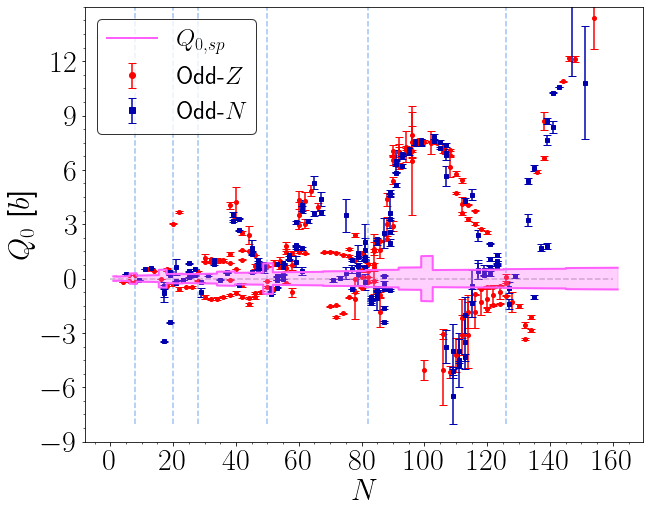

In [152]:
# s-p quadrupole

plt.figure(figsize=((10,8)))
plt.rcParams["text.usetex"] = True

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataqdep_odd[3])):
    try: 
        if len(dataqdep_odd[3][i]) == 2:
            lower_error.append(dataqdep_odd[3][i][1])
            upper_error.append(dataqdep_odd[3][i][0])
    except: 
        lower_error.append(dataqdep_odd[3][i])
        upper_error.append(dataqdep_odd[3][i])
# =================================================================================        

# Odd Z
#dataq_Z_Z = [] 
#dataq_A_Z = [] 
dataq_A = [] 

dataq_A_oddZ = [] 
dataq_A_oddN = [] 

dataq_Z = [] 
dataq_N = [] 

dataqq_oddZ = [] 
dataq_lower_oddZ = [] 
dataq_upper_oddZ = [] 

dataqq_oddN = [] 
dataq_lower_oddN = [] 
dataq_upper_oddN = [] 

dataq_loweroddZ = [] 
dataq_upperoddZ = [] 

dataq_loweroddN = [] 
dataq_upperoddN = [] 

dataq_jp = []


for i in range(len(dataqdep_odd[0])):
    
    if dataqdep_odd[0][i]%2==1:
        dataq_Z.append(dataqdep_odd[1][i] - dataqdep_odd[0][i])
        dataq_A_oddZ.append(dataqdep_odd[1][i])
        dataqq_oddZ.append(dataqdep_odd[2][i])
        dataq_loweroddZ.append(lower_error[i])
        dataq_upperoddZ.append(upper_error[i])
        
    else:
        
        dataq_N.append(dataqdep_odd[1][i] - dataqdep_odd[0][i])
        dataq_A_oddN.append(dataqdep_odd[1][i])
        dataqq_oddN.append(dataqdep_odd[2][i])    
        dataq_loweroddN.append(lower_error[i])
        dataq_upperoddN.append(upper_error[i])   
        
    
asymmetric_erroroddZ = np.array(list(zip(dataq_loweroddZ, dataq_upperoddZ))).T
asymmetric_erroroddN = np.array(list(zip(dataq_loweroddN, dataq_upperoddN))).T

plt.errorbar(dataq_Z, dataqq_oddZ, yerr=asymmetric_erroroddZ, fmt='o', color = "#FF0000" ,markersize=4, capsize=4, label="Odd-$Z$") 
plt.errorbar(dataq_N, dataqq_oddN, yerr=asymmetric_erroroddN, fmt='s', color = "#0000AF" ,markersize=4, capsize=4, label="Odd-$N$") 
plt.vlines(8, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(20, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(28, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(50, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(82, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)
plt.vlines(126, -8, 15, colors='#659bec', linestyles='--', alpha=0.6)

plt.ylim(-8, 15)

plt.xticks(np.arange(0,300,20), fontsize=30)
plt.yticks(np.arange(-9, 15,3), fontsize=30)


plt.xlabel("$N$", fontsize=30)
plt.ylabel(r"$Q_0$ [$b$]", size=30)
#plt.text(150, 7.8, "(a)", fontsize=45, weight='bold' )
plt.hlines(0, 0, 160, colors='gray', linestyles='--', alpha=0.5)

plt.minorticks_on()
# plt.tick_params(axis='x', which='minor', bottom=False)
# plt.tick_params(axis='y', which='minor', length=2, width=1)



# # Adding sp-lines
# plt.plot(np.arange(0,165,5), Q_0_sp(1/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(3/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(5/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(7/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), Q_0_sp(9/2,np.arange(0,165,5)), "o-")

# plt.plot(np.arange(0,165,5), -1*Q_0_sp(1/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(3/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(5/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(7/2,np.arange(0,165,5)), "o-")
# plt.plot(np.arange(0,165,5), -1*Q_0_sp(9/2,np.arange(0,165,5)), "o-")

c3 = "#FF60FD"

plt.plot(N_values, -1*np.array(Q0_values), "-", c=c3, zorder=30, linewidth=2)
plt.plot(N_values, Q0_values, "-", c=c3, zorder=30, linewidth=2, label=r"$Q_{0,sp}$")

# Fill the area between the two curves
plt.fill_between(
    N_values,
    Q0_values,
    -1*np.array(Q0_values),
    color=c3,
    alpha=0.3,   # transparency
    zorder=10
)



plt.legend(fontsize=25, edgecolor="black", loc="upper left", markerscale=1.5)
plt.savefig("QExp1_cb-intr-sp-odd-A.svg", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-intr-sp-odd-A.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.savefig("QExp1_cb-intr-sp-odd-A.pdf", facecolor='white', bbox_inches='tight')

plt.show()

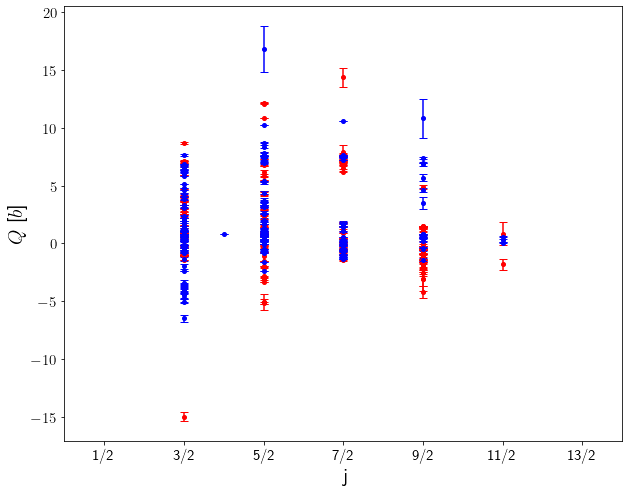

In [131]:
plt.figure(figsize=((10,8)))

# Error bars ======================================================================
lower_error = []
upper_error = []
for i in range(len(dataqdep_odd[3])):
    try: 
        if len(dataqdep_odd[3][i]) == 2:
            lower_error.append(dataqdep_odd[3][i][1])
            upper_error.append(dataqdep_odd[3][i][0])
    except: 
        lower_error.append(dataqdep_odd[3][i])
        upper_error.append(dataqdep_odd[3][i])
# =================================================================================        

# Odd Z
#dataqdep_odd_Z_Z = [] 
#dataqdep_odd_A_Z = [] 
dataqdep_odd_mu_Z = [] 
dataqdep_odd_lower_Z = [] 
dataqdep_odd_upper_Z = [] 
#dataqdep_odd_E_Z = [] 
dataqdep_odd_jp_Z = []

# Odd N
#dataqdep_odd_Z_N = [] 
#dataqdep_odd_A_N = [] 
dataqdep_odd_mu_N = [] 
dataqdep_odd_lower_N = [] 
dataqdep_odd_upper_N = [] 
#dataqdep_odd_E_N = [] 
dataqdep_odd_jp_N = []

for i in range(len(dataqdep_odd[0])):
    
    if (dataqdep_odd[0][i]%2==1):
#         # Append in the odd Z array
#         if "(" in dataqdep_odd[5][i]:
#             jjpp = dataqdep_odd[5][i].replace("(","")
#             jjpp = jjpp.replace(")","")
            
#             if "/" not in jjpp:
#                 continue
                
#             jjpp = float(jjpp.split("/")[0])/2
#         else:
            
#             if "/" not in dataqdep_odd[5][i]:
#                 continue
#             jjpp = float(dataqdep_odd[5][i].split("/")[0])/2
        
        jjpp = float(dataqdep_odd[5][i])
        dataqdep_odd_mu_Z.append(dataqdep_odd[2][i])
        dataqdep_odd_lower_Z.append(lower_error[i])
        dataqdep_odd_upper_Z.append(upper_error[i])
        dataqdep_odd_jp_Z.append(jjpp)
    
    if (dataqdep_odd[0][i]%2==0):
#         # Append in the odd N array
#         if "(" in dataqdep_odd[5][i]:
#             jjpp = dataqdep_odd[5][i].replace("(","")
#             jjpp = jjpp.replace(")","")
            
#             if "/" not in jjpp:
#                 continue
                
#             jjpp = float(jjpp.split("/")[0])/2
#         else:
#             if "/" not in dataqdep_odd[5][i]:
#                 continue
#             jjpp = float(dataqdep_odd[5][i].split("/")[0])/2
        
        jjpp = float(dataqdep_odd[5][i])
        dataqdep_odd_mu_N.append(dataqdep_odd[2][i])
        dataqdep_odd_lower_N.append(lower_error[i])
        dataqdep_odd_upper_N.append(upper_error[i])
        dataqdep_odd_jp_N.append(jjpp)
    
asymmetric_error_Z = np.array(list(zip(dataqdep_odd_lower_Z, dataqdep_odd_upper_Z))).T
plt.errorbar(dataqdep_odd_jp_Z, dataqdep_odd_mu_Z, yerr=asymmetric_error_Z, fmt='o', color = "red" ,markersize=4, capsize=4) 
asymmetric_error_N = np.array(list(zip(dataqdep_odd_lower_N, dataqdep_odd_upper_N))).T
plt.errorbar(dataqdep_odd_jp_N, dataqdep_odd_mu_N, yerr=asymmetric_error_N, fmt='o', color = "blue", markersize=4, capsize=4) 


#plt.yticks(np.arange(int(min(dataqdep_odd[2]))-1, int(max(dataqdep_odd[2]))+2, 1), size=20)
plt.xlim(0,7)
#plt.ylim(-2.5,10.5)

plt.xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5],["1/2","3/2","5/2","7/2","9/2","11/2","13/2"], fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel("j", size=20)
plt.ylabel(r"$Q$ [$b$]", size=20)
plt.show()

In [211]:
stable_nuclei = [
    (1, 0),    # H-1
    (2, 2),    # He-4
    (3, 4),    # Li-7
    (4, 5),    # Be-9
    (5, 6),    # B-11
    (6, 6),    # C-12
    (7, 7),    # N-14
    (8, 8),    # O-16
    (9, 10),   # F-19
    (10, 10),  # Ne-20
    (11, 12),  # Na-23
    (12, 12),  # Mg-24
    (13, 14),  # Al-27
    (14, 14),  # Si-28
    (15, 16),  # P-31
    (16, 16),  # S-32
    (17, 18),  # Cl-35
    (18, 22),  # Ar-40
    (19, 20),  # K-39
    (20, 20),  # Ca-40
    (21, 24),  # Sc-45
    (22, 26),  # Ti-48
    (23, 28),  # V-51
    (24, 28),  # Cr-52
    (25, 30),  # Mn-55
    (26, 30),  # Fe-56
    (27, 32),  # Co-59
    (28, 30),  # Ni-58
    (29, 34),  # Cu-63
    (30, 34),  # Zn-64
    (31, 39),  # Ga-69
    (32, 41),  # Ge-73
    (33, 42),  # As-75
    (34, 45),  # Se-79
    (35, 46),  # Br-81
    (36, 48),  # Kr-84
    (37, 48),  # Rb-85
    (38, 50),  # Sr-88
    (39, 50),  # Y-89
    (40, 51),  # Zr-91
    (41, 52),  # Nb-93
    (42, 54),  # Mo-98
    (43, 55),  # Tc (no stable isotope)
    (44, 57),  # Ru-101
    (45, 58),  # Rh-103
    (46, 60),  # Pd-106
    (47, 61),  # Ag-107
    (48, 64),  # Cd-112
    (49, 66),  # In-115
    (50, 70),  # Sn-120
    (51, 71),  # Sb-122
    (52, 76),  # Te-128
    (53, 74),  # I-127
    (54, 77),  # Xe-131
    (55, 78),  # Cs-133
    (56, 81),  # Ba-137
    (57, 82),  # La-139
    (58, 82),  # Ce-140
    (59, 82),  # Pr-141
    (60, 84),  # Nd-144
    (61, 84),  # Pm (no stable isotope)
    (62, 88),  # Sm-152
    (63, 89),  # Eu-153
    (64, 93),  # Gd-157
    (65, 93),  # Tb-159
    (66, 97),  # Dy-163
    (67, 98),  # Ho-165
    (68, 99),  # Er-167
    (69, 100), # Tm-169
    (70, 100), # Yb-170
    (71, 104), # Lu-175
    (72, 106), # Hf-178
    (73, 108), # Ta-181
    (74, 110), # W-184
    (75, 111), # Re-187
    (76, 114), # Os-190
    (77, 115), # Ir-193
    (78, 117), # Pt-195
    (79, 118), # Au-197
    (80, 122), # Hg-202
    (81, 124), # Tl-205
    (82, 126),  # Pb-208
    (83, 126) # Bi-209 
]